# KPI Anomaly Detection

Group: 
- Zihang WANG
- Liyang FANG

Dataset:
* [KPI Anomaly Detectionn](https://competition.aiops-challenge.com/home/competition/1484452272200032281)

## EDA

### Data Preparation

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings("ignore")

In [3]:
data_folder = "../data/"

train_file = "train.csv"
# test_file = "test.csv"

train_path = data_folder + train_file
# test_path = data_folder + test_file

In [4]:
df_train = pd.read_csv(train_path).rename(columns={"KPI ID": "kpi_id"})
df_train["datetime"] = pd.to_datetime(df_train.timestamp, unit="s")

In [5]:
# df_test = pd.read_csv(test_path).rename(columns={"KPI ID": "kpi_id"})
# df_test["datetime"] = pd.to_datetime(df_test.timestamp, unit="s")

In [5]:
df_train.head()

,timestamp,value,label,kpi_id,datetime
0,1493568000,1.901639,0,02e99bd4f6cfb33f,2017-04-30 16:00:00
1,1493568060,1.786885,0,02e99bd4f6cfb33f,2017-04-30 16:01:00
2,1493568120,2.000000,0,02e99bd4f6cfb33f,2017-04-30 16:02:00
3,1493568180,1.885246,0,02e99bd4f6cfb33f,2017-04-30 16:03:00
4,1493568240,1.819672,0,02e99bd4f6cfb33f,2017-04-30 16:04:00


In [6]:
df_train.shape

(2476315, 5)

In [7]:
print(f"Missing values is {df_train.isnull().sum().sum()}")
print(f"Duplicated values is {df_train.duplicated().sum()}")
print(f"Number of unique KPI IDs are {df_train.kpi_id.nunique()}")

Missing values is 0
Duplicated values is 0
Number of unique KPI IDs are 26


Text(0.5, 9.444444444444438, 'missing dates count')

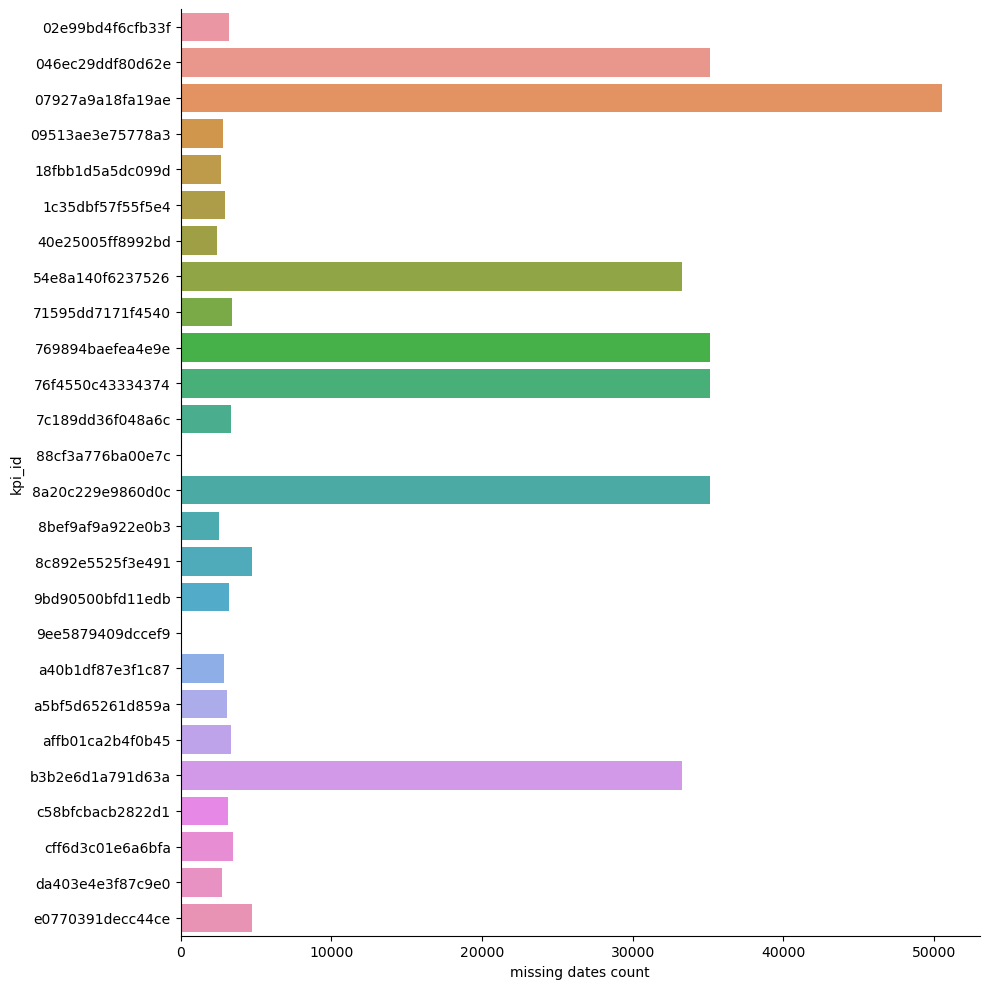

In [8]:
missing_date_per_kip = (
    df_train.groupby("kpi_id")
    .apply(
        lambda x: pd.Series(
            pd.date_range(
                start=x.datetime.min(), end=x.datetime.max(), freq="1min"
            ).difference(x.datetime)
        )
    )
    .reset_index(drop=False)
)
missing_date_per_kip = missing_date_per_kip.rename(columns={0: "datetime"}).drop(
    columns=["level_1"]
)
sns.catplot(
    y="kpi_id", x=None, data=missing_date_per_kip, kind="count", orient="h", height=10
)
plt.xlabel("missing dates count")

In [9]:
def fill_na(data):
    start = data.datetime.min()
    end = data.datetime.max()
    idx = pd.date_range(start=start, end=end, freq="1min")
    data.set_index("datetime", inplace=True)
    data = data.reindex(idx)

    data.timestamp = data.index.astype(int) / 10**9
    data.kpi_id = data.kpi_id.unique()[0]

    data.fillna(
        method="ffill", inplace=True
    )  # ffill: propagate last valid observation forward to next valid
    return data.reset_index(drop=False).rename(columns={"index": "datetime"})


df_train = df_train.groupby("kpi_id").apply(fill_na).reset_index(drop=True)
missing_date_per_kip = (
    df_train.groupby("kpi_id")
    .apply(
        lambda x: pd.Series(
            pd.date_range(start=x.datetime.min(), end=x.datetime.max(), freq="1min")
            .difference(x.datetime)
            .size
        )
    )
    .reset_index(drop=False)
    .rename(columns={0: "missing_dates"})
)

print(f"any missing date? {missing_date_per_kip.missing_dates.any()}")

any missing date? False


### Anomaly exploration 

In [10]:
print(
    f"Percentage of anomalies is {len(df_train[df_train['label'] == 1]) / len(df_train) * 100:.2f}%"
)

Percentage of anomalies is 2.11%


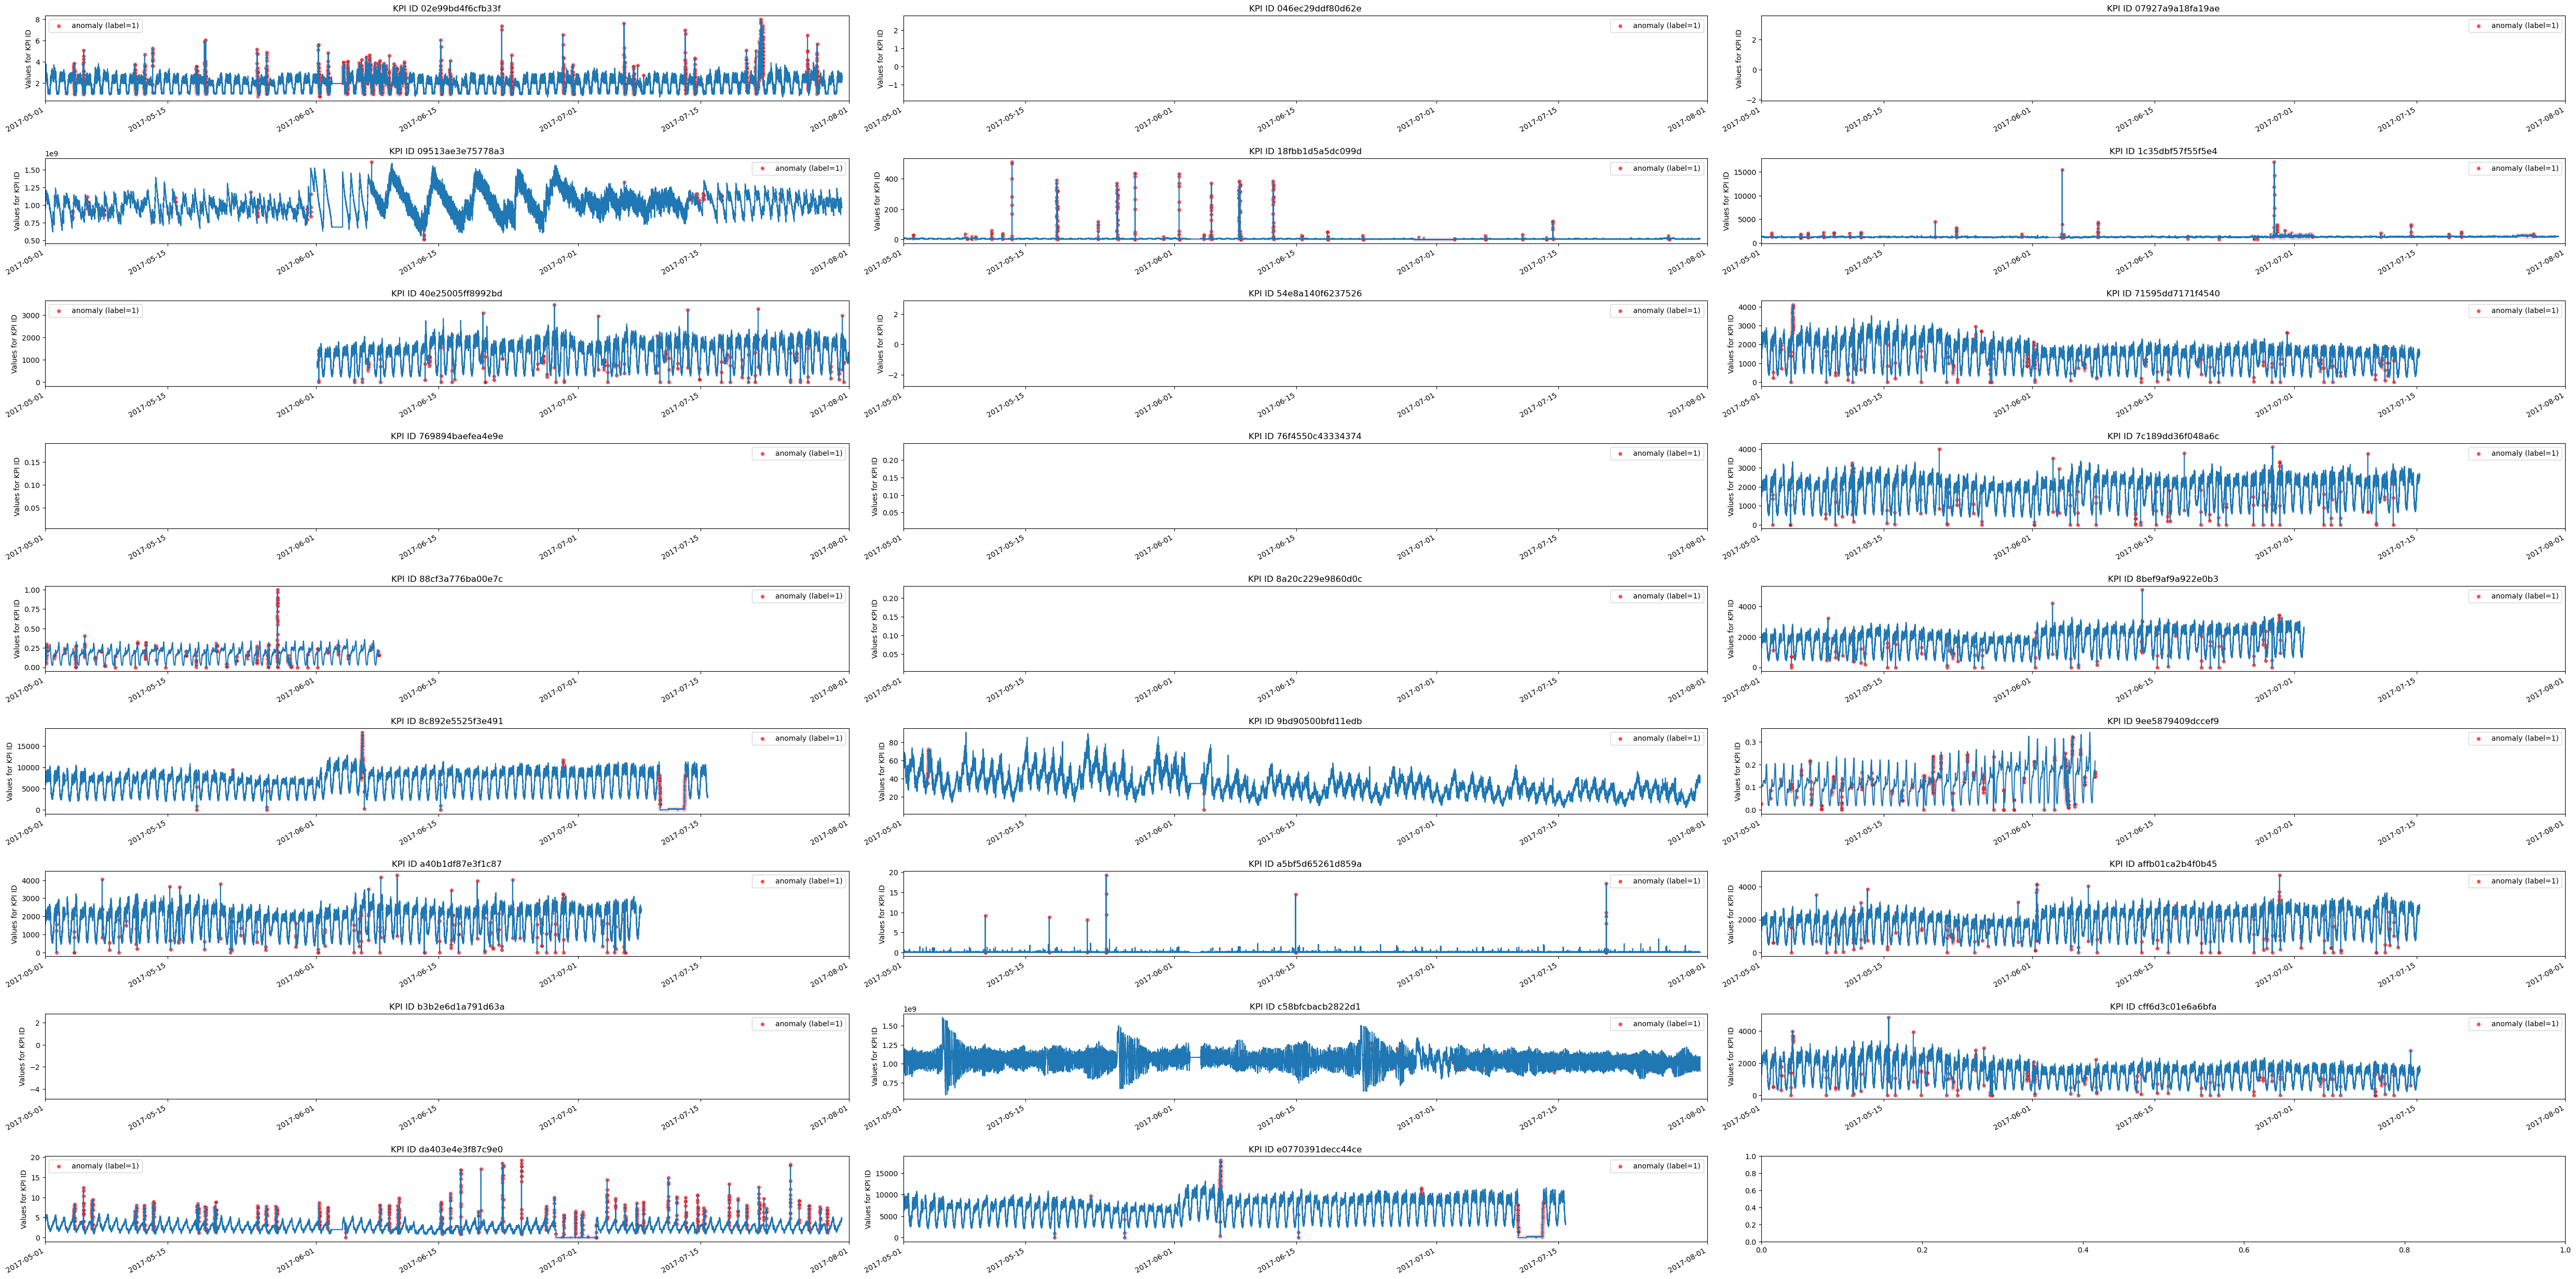

In [11]:
fig, axs = plt.subplots(9, 3, figsize=(50, 25))

for kpi_id, ax in zip(df_train.kpi_id.unique(), axs.flatten()):
    data = df_train[df_train.kpi_id == kpi_id]
    sns.lineplot(data=data, x="datetime", y="value", ax=ax)
    sns.scatterplot(
        data=data[data.label == 1],
        x="datetime",
        y="value",
        color="r",
        s=30,
        alpha=0.7,
        label="anomaly (label=1)",
        ax=ax,
    )
    ax.set_xlim(datetime.datetime(2017, 5, 1), datetime.datetime(2017, 8, 1))
    ax.legend()
    ax.title.set_text(f"KPI ID {kpi_id}")
    ax.set_ylabel("Values for KPI ID")
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
plt.tight_layout(pad=2)
plt.show()

### Data Precessing

From the graph we ploted, There are three typical shapes of plots.
 - Period, eg: '7c189dd36f048a6c'
 - Stable, eg: '18fbbld5a5dc099d'
 - Unstable, eg: '09513ae3e75778a3'
We choose the selected KPI to do the further detection in the following sections

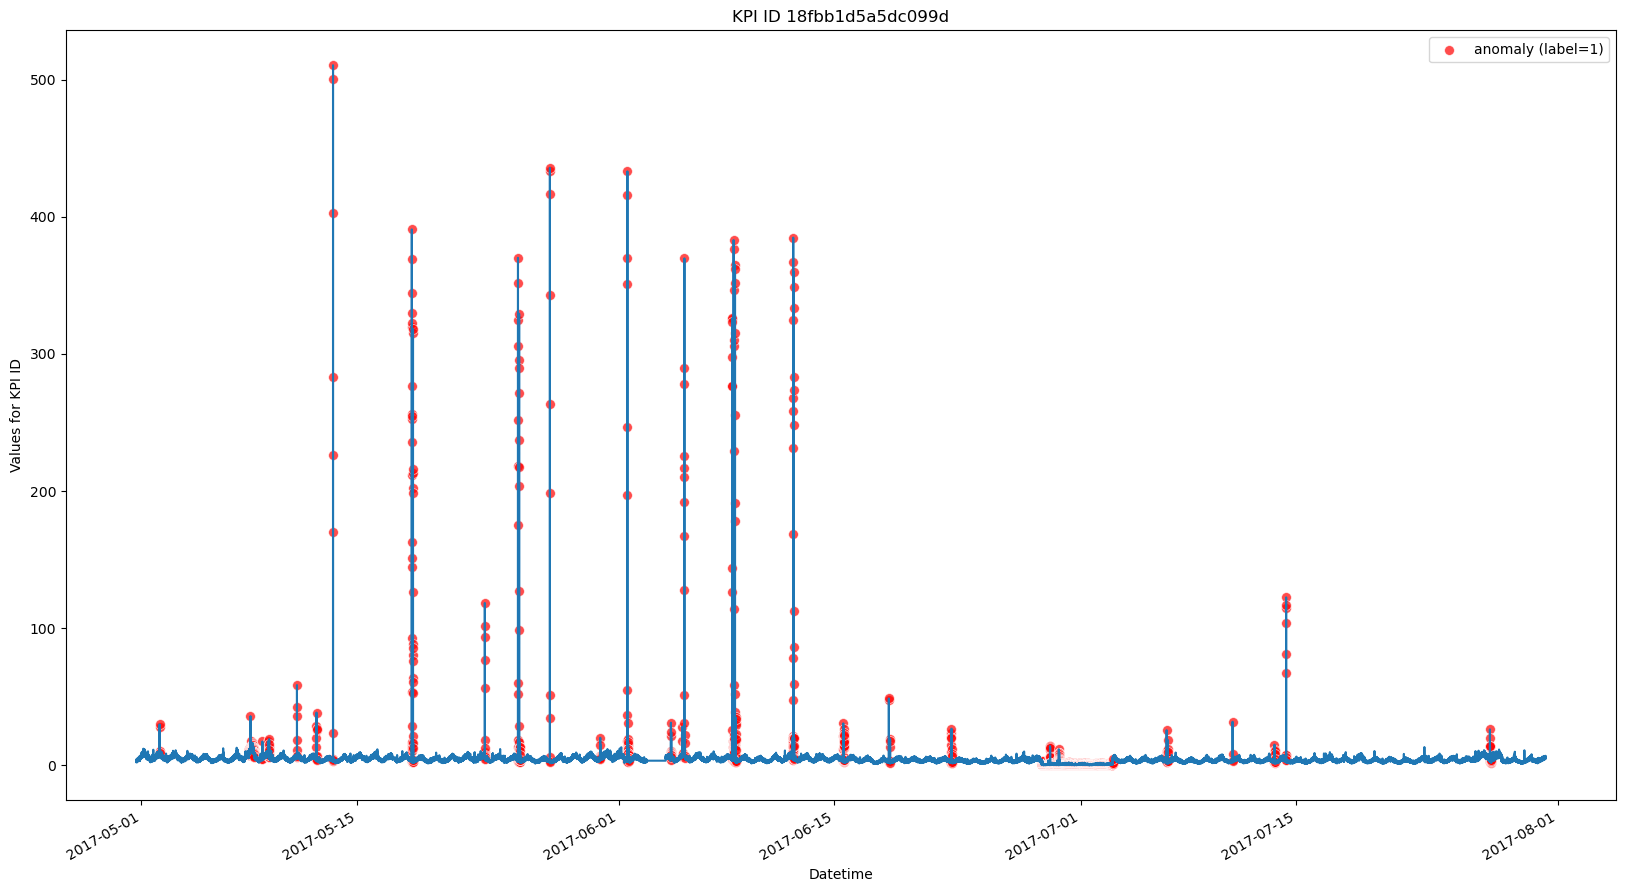

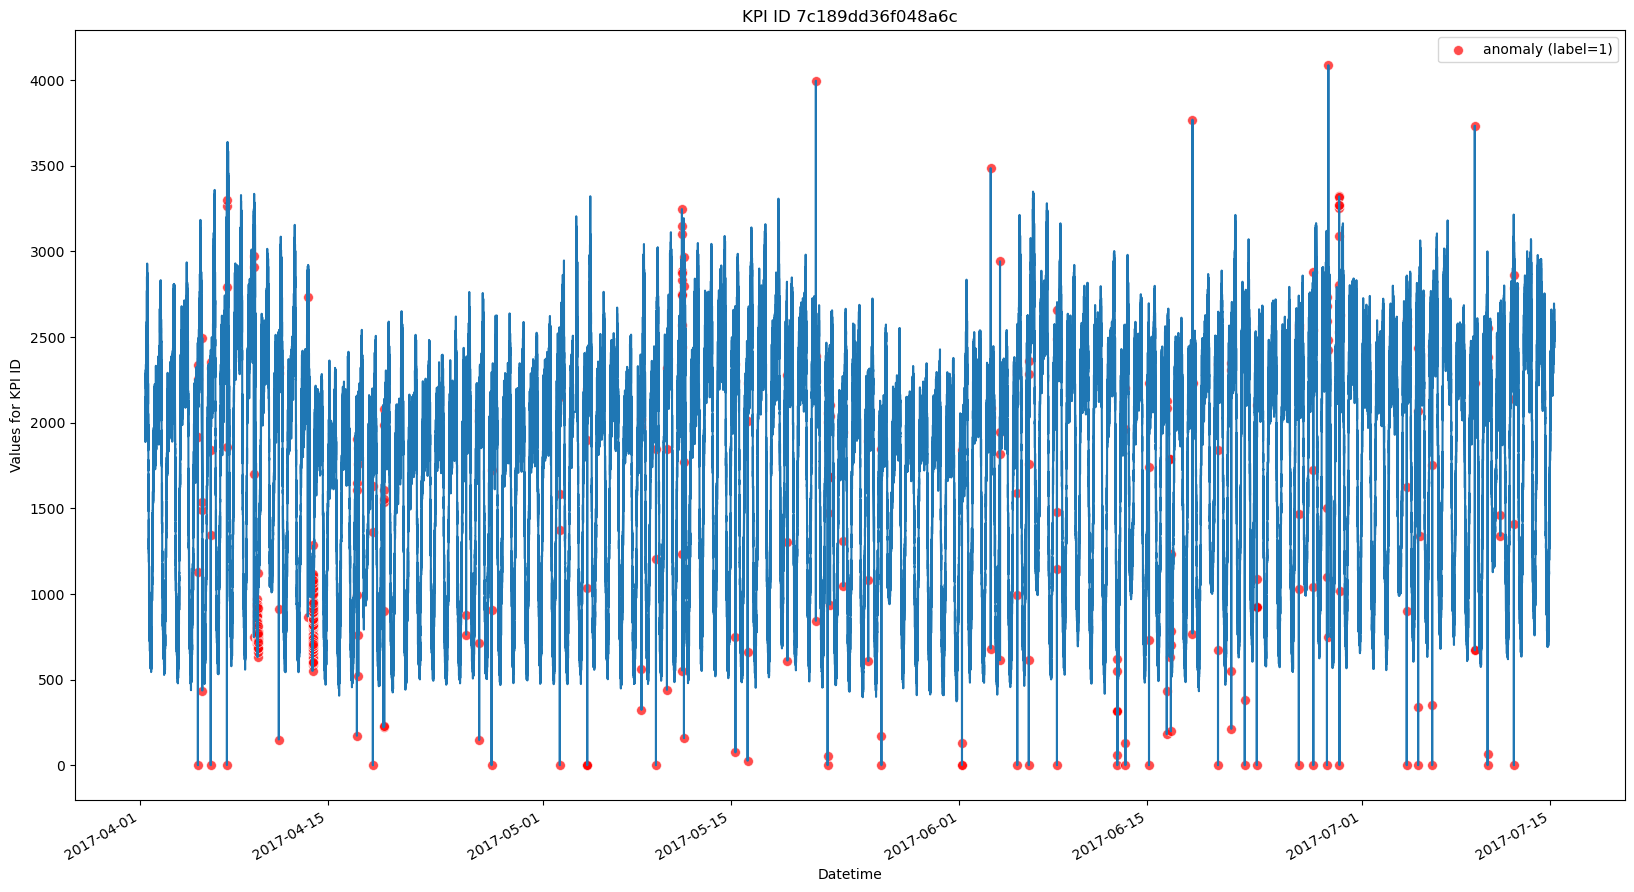

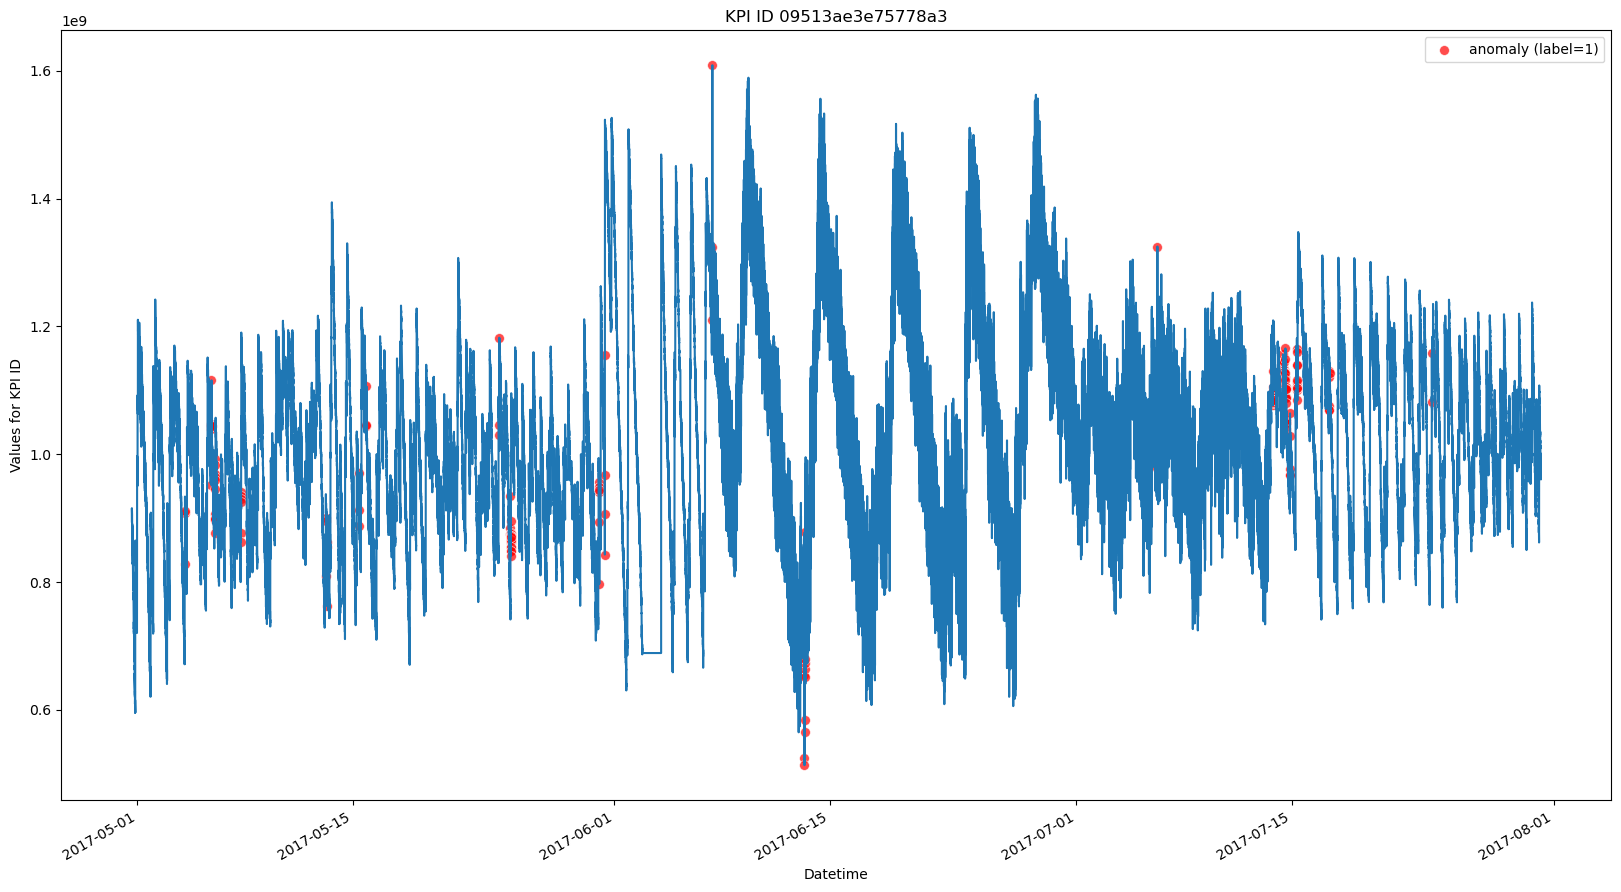

In [12]:
from utilities import plot_anomaly

KPI_IDs = ["18fbb1d5a5dc099d", "7c189dd36f048a6c", "09513ae3e75778a3"]
for KPI_ID in KPI_IDs:
    data = df_train[df_train.kpi_id == KPI_ID]
    plot_anomaly(data)

### Data Visulization

#### Stationarity

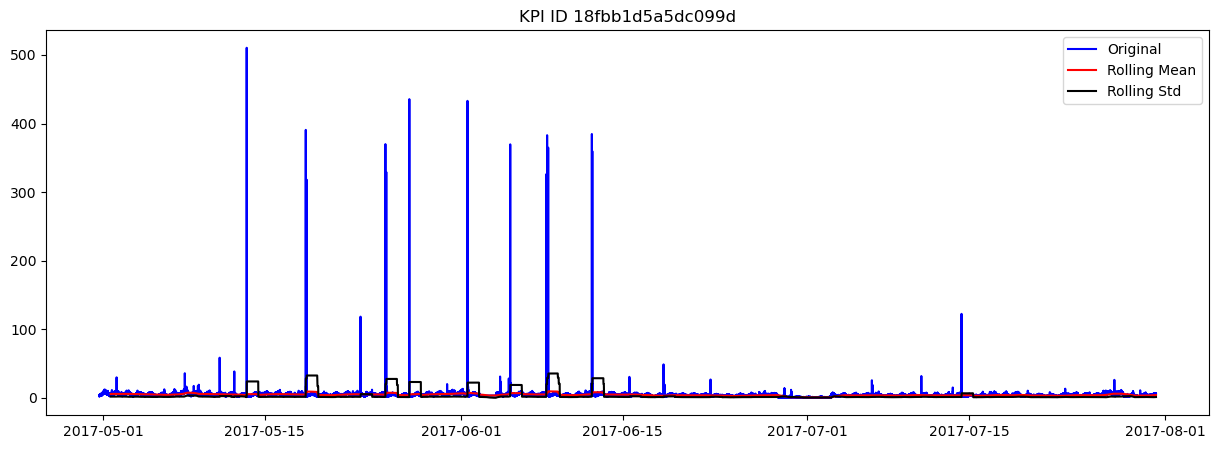

Results of Dickey Fuller Test:
Test Statistic                    -32.755889
p-value                             0.000000
#Lags Used                         71.000000
Number of Observations Used    131723.000000
Critical Value (1%)                -3.430400
Critical Value (5%)                -2.861562
Critical Value (10%)               -2.566782
dtype: float64
KPI ID 18fbb1d5a5dc099dis stationary


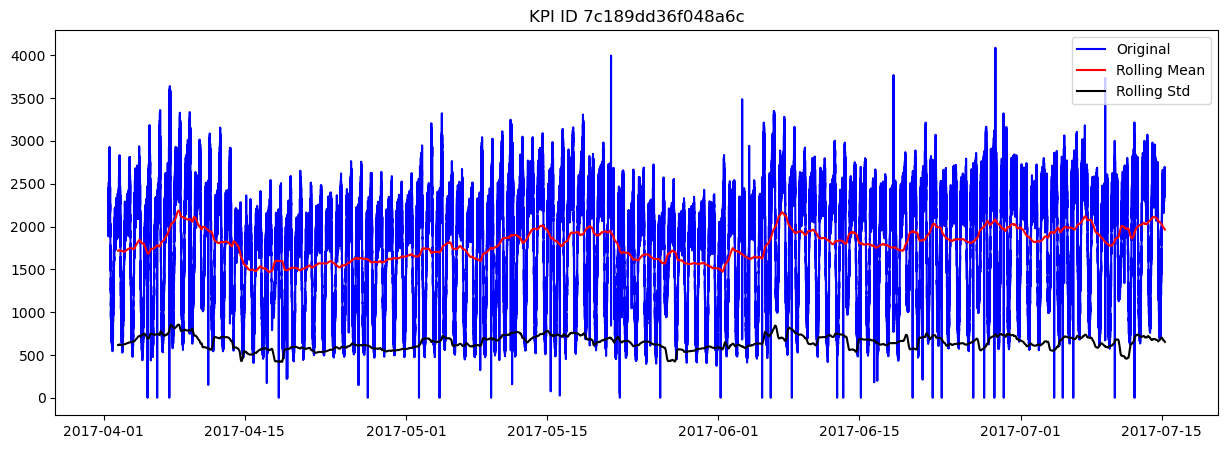

Results of Dickey Fuller Test:
Test Statistic                    -24.390016
p-value                             0.000000
#Lags Used                         75.000000
Number of Observations Used    150984.000000
Critical Value (1%)                -3.430393
Critical Value (5%)                -2.861559
Critical Value (10%)               -2.566780
dtype: float64
KPI ID 7c189dd36f048a6cis stationary


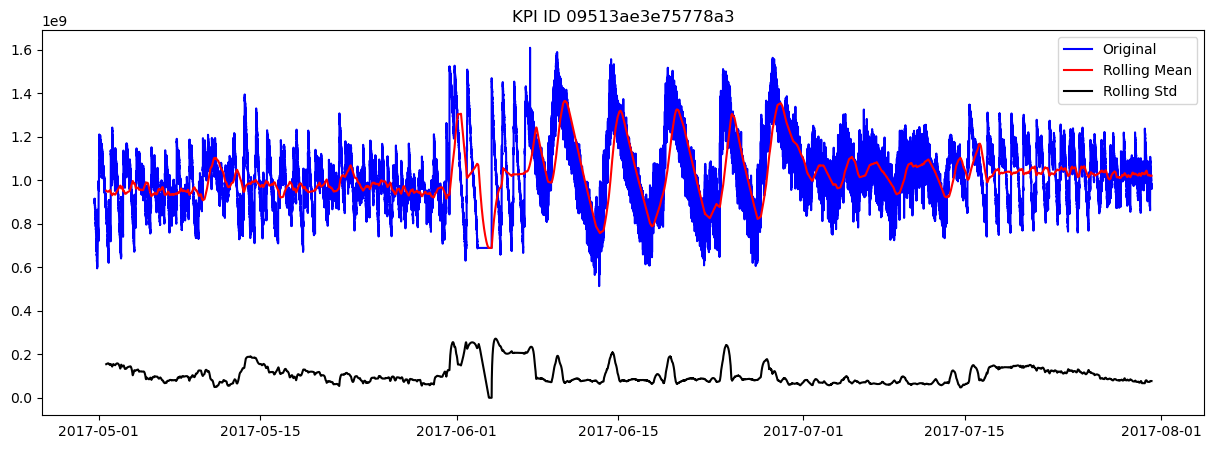

Results of Dickey Fuller Test:
Test Statistic                -1.045444e+01
p-value                        1.410628e-18
#Lags Used                     6.800000e+01
Number of Observations Used    1.317160e+05
Critical Value (1%)           -3.430400e+00
Critical Value (5%)           -2.861562e+00
Critical Value (10%)          -2.566782e+00
dtype: float64
KPI ID 09513ae3e75778a3is stationary


In [28]:
from utilities import test_stationarity

for KPI_ID in KPI_IDs:
    data = df_train[df_train.kpi_id == KPI_ID]
    test_stationarity(data)

From the stationary test, it is not hard to find the rolling mean and std is almost parallel to the x-ais, moreover, the Fuller test gives us the clear conclusion: the data is staionary since the test is big negative number and the p-value is less than 0.05. From this analysis, we don't need to do more transform to our data for the forward modeling.

#### Seasonality

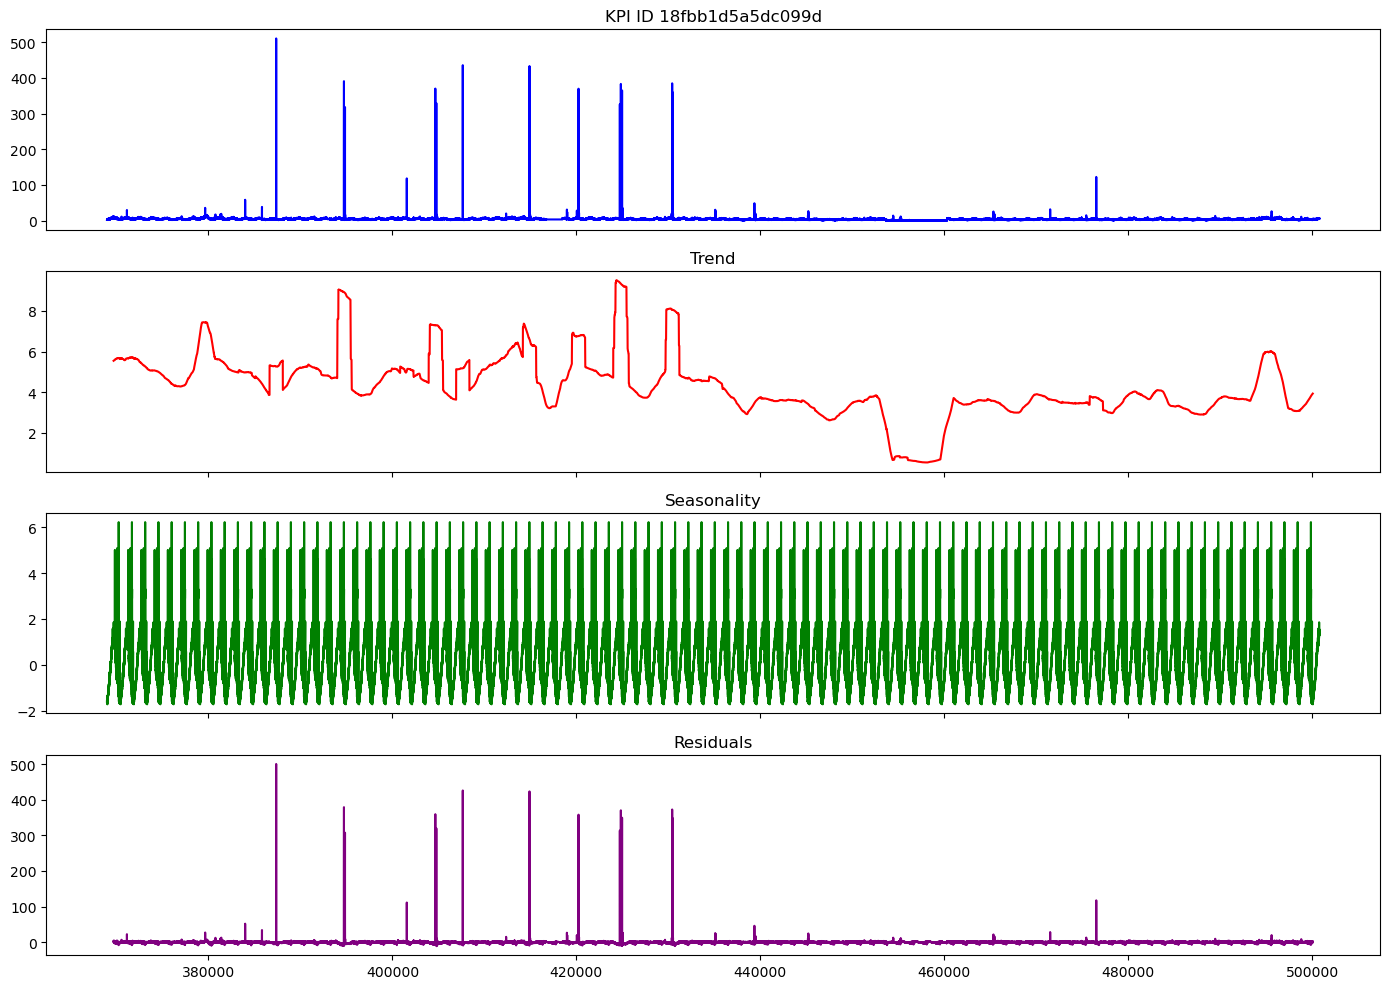

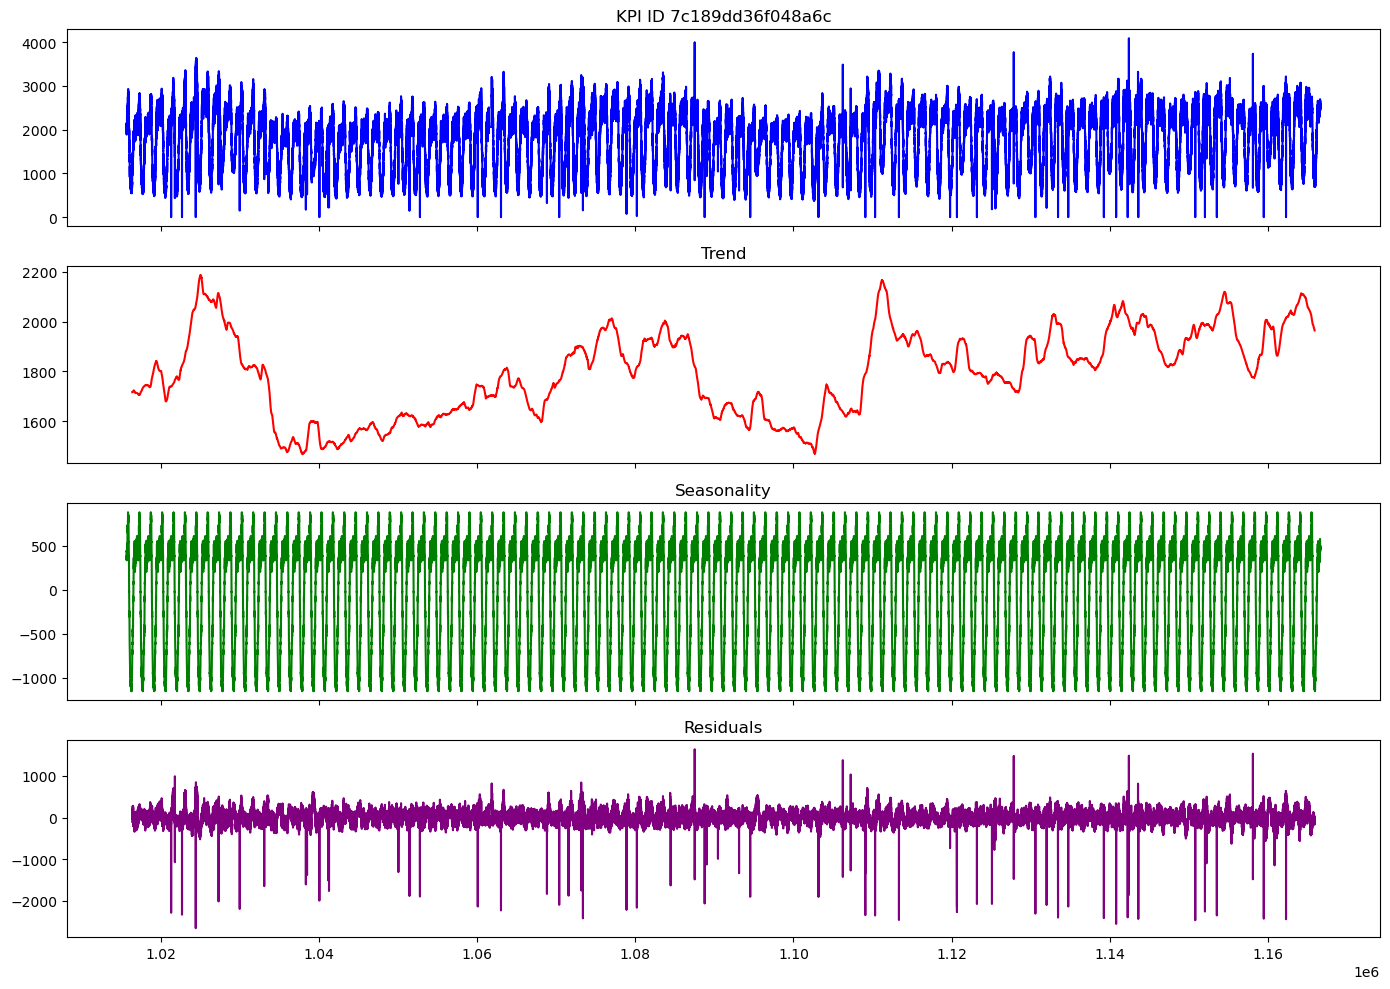

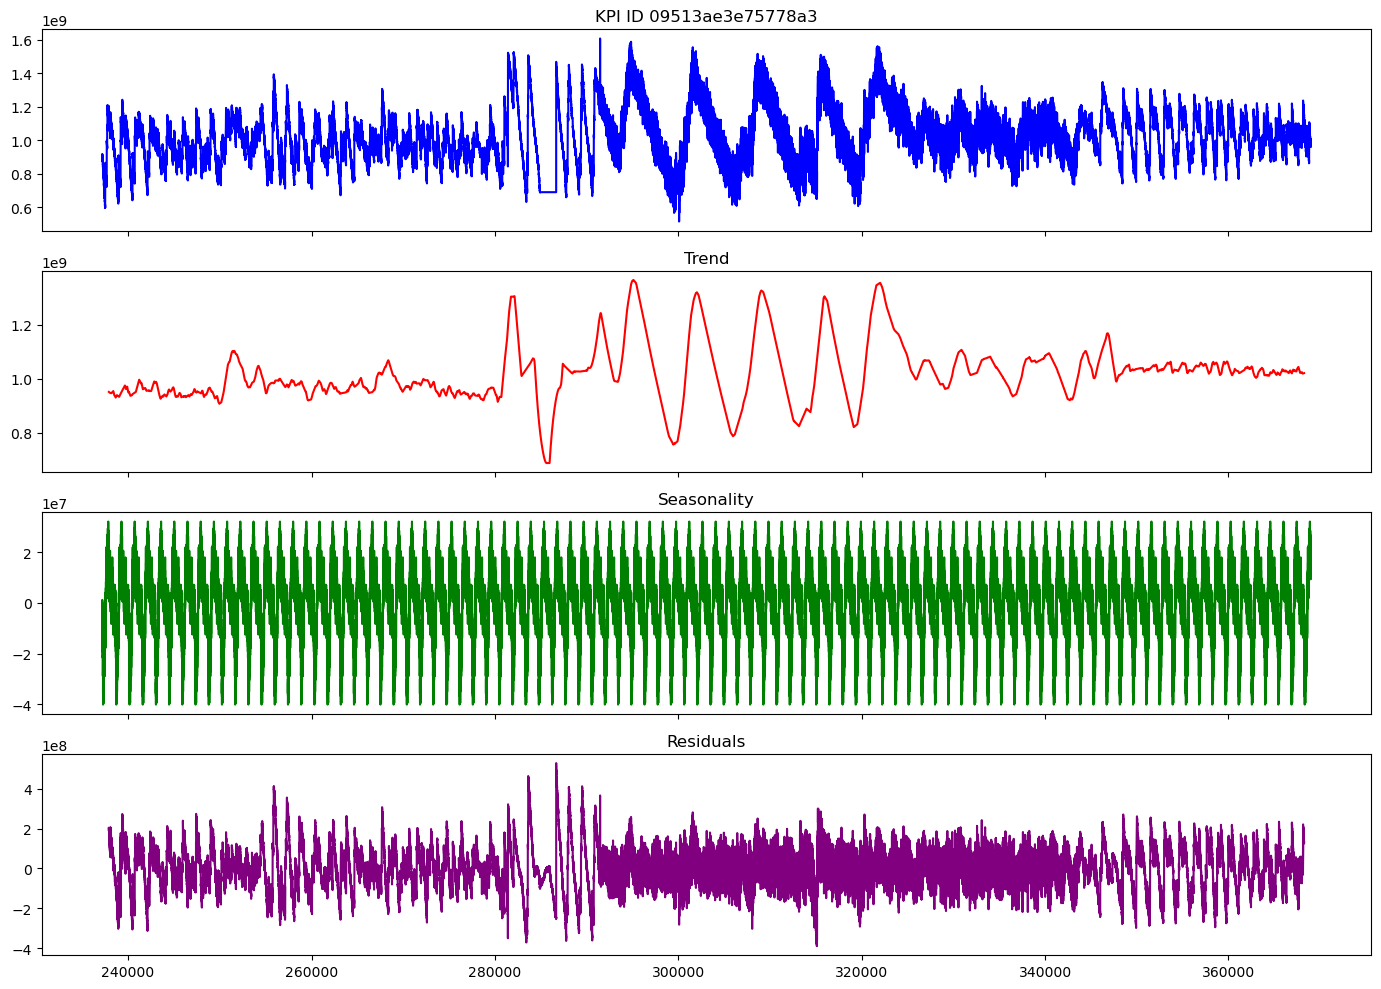

In [23]:
from utilities import season_decompose

for KPI_ID in KPI_IDs:
    data = df_train[df_train.kpi_id == KPI_ID]
    trend, seasonal, residual = season_decompose(data)

From the seasonality analysis, our data has a strong seasonality. Stationarity refers to the overall statistical properties being constant over time, whereas seasonality refers to periodic patterns within the data. The presence of seasonality does not contradict stationarity if the seasonal patterns are regular and predictable.

#### ACF & PACF

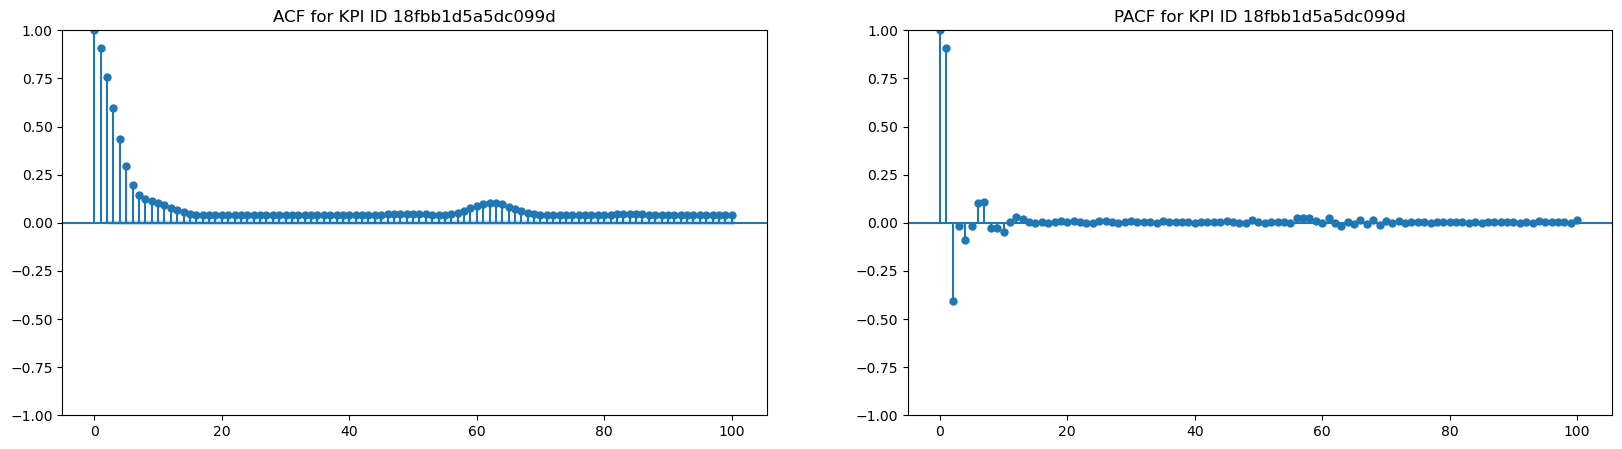

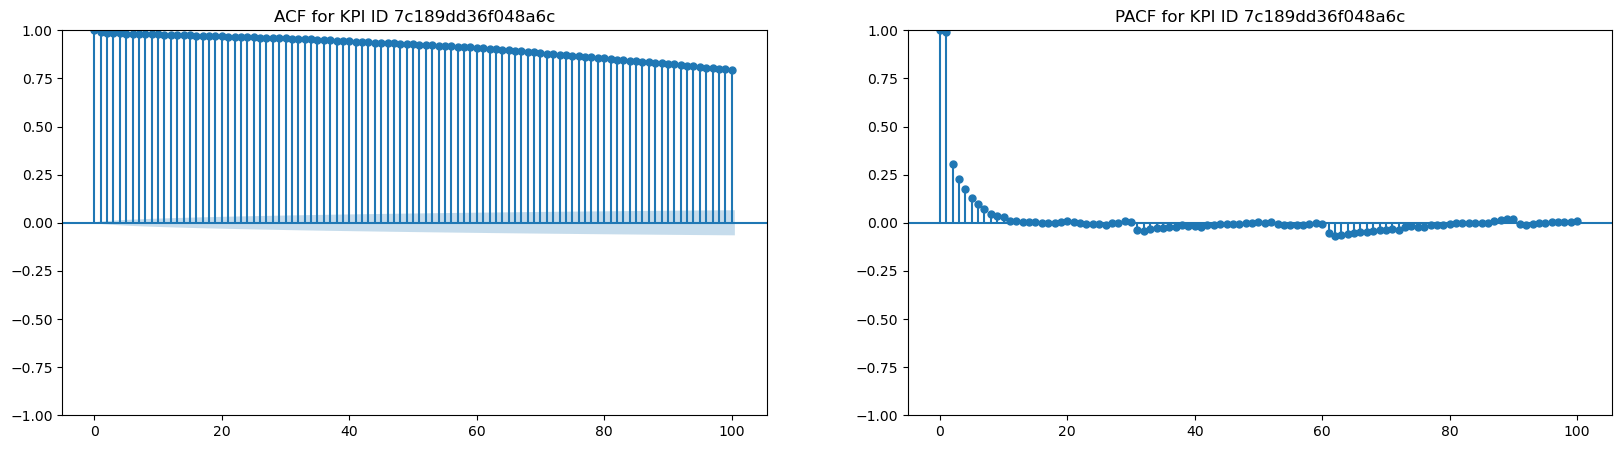

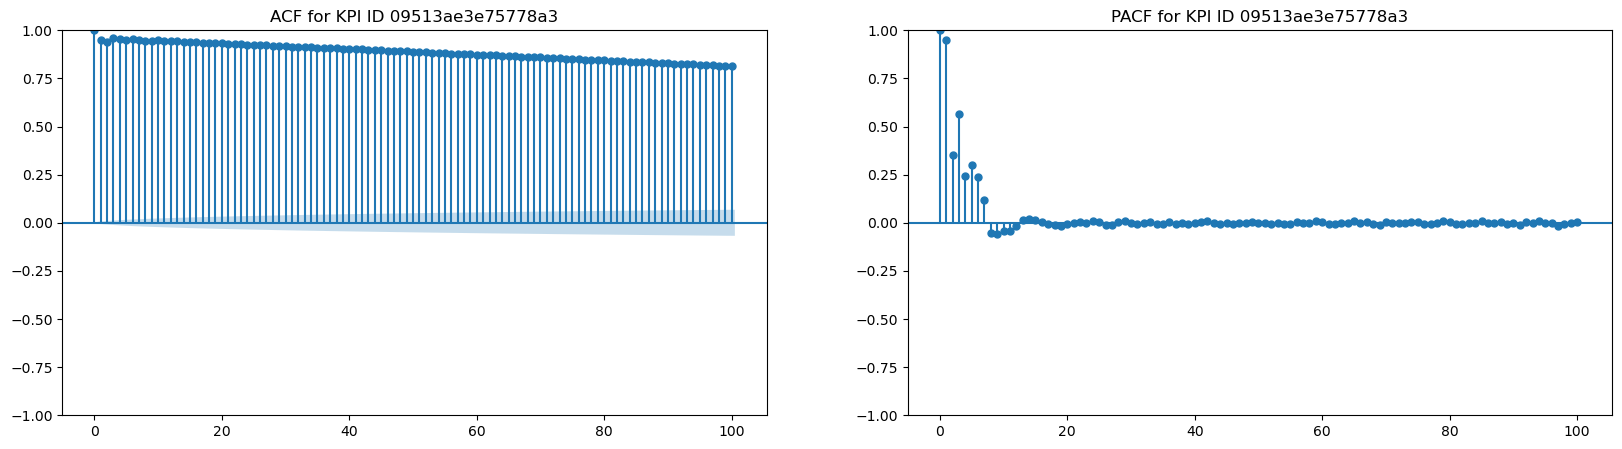

In [27]:
from utilities import plot_acf_pacf

for KPI_ID in KPI_IDs:
    data = df_train[df_train.kpi_id == KPI_ID]
    plot_acf_pacf(data)

The ACF showed a slowly decaying pattern, while the PACF cuts off more sharply. This combination typically suggests an autoregressive (AR) process is more appropriate than a moving average (MA) process.

## Anomaly Detection

### Heuristics based STL Decomposition